In [1]:
# %load "quadrature.py"
class Quadrature:
    @staticmethod
    def computeMean(z, Wi, y):
        return np.dot(np.dot(z.T, Wi), y)[0][0]

    @staticmethod
    def computeVariance(gp, z, Wi, A, B, I):
        lsq = gp.kern.lengthscale[0]
        w = gp.kern.variance[0]
        determ = np.linalg.det(2 * np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
        return (w * determ - np.dot(np.dot(z.T, Wi), z))[0][0]

    @staticmethod
    def computeZ(gp, X, i, A, B, b, I):
        x = X[i, :]
        lsq = gp.kern.lengthscale[0]
        w = gp.kern.variance[0]
        determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), np.linalg.inv(A + B)), (x - b).T))
        return w * determ * expon

    @staticmethod
    def integrate(gp, b, v):
        dim = gp.X.shape[1]
        A = gp.kern.lengthscale[0] * np.diag(np.ones(dim))
        B = v * np.diag(np.ones(dim))
        b = b
        I = np.identity(dim)
        X = gp.X
        Y = gp.Y

        K = gp.kern.K(X)
        Ky = K.copy()
        Wi, LW, LWi, W_logdet = GPy.util.linalg.pdinv(Ky)

        z = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            z[i, :] = Quadrature.computeZ(gp, X, i, A, B, b, I)
        return (Quadrature.computeMean(z, Wi, Y), Quadrature.computeVariance(gp, z, Wi, A, B, I))

In [2]:
run "robotworld.py"


KeyboardInterrupt: 

In [3]:
import scipy.stats
import numpy as np
def f_temp(x):
    return [scipy.stats.norm(3, 1).pdf(x[0])]
def f(x):
    return [scipy.stats.norm(3, 1).pdf(x[0]),scipy.stats.norm(0, 1).pdf(x[1])]
def flambda(a):
    modifier = scipy.stats.norm(0, 1).pdf(a)
    def f(x):
        return [scipy.stats.norm(3, 1).pdf(x[0]) * modifier]
    return f

 /home/nishad/Documents/push-pybullet/nish/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3124: UserWarning:Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-2.2553536424527927, right=-2.2553536424527927


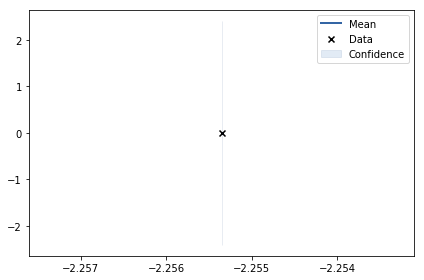

In [181]:
gp.plot()

In [188]:
X = np.random.uniform(-10,10,size=(3,1))
Y = X.copy()
Y = np.apply_along_axis(flambda(0), 1, Y)
gp = GPy.models.GPRegression(X,Y,GPy.kern.src.rbf.RBF(input_dim=1))

In [190]:
Quadrature.integrate(gp,np.array([0.0]),1.0)

(0.0015093126469388374, array([[0.05306132]]))

In [21]:
A = {}
actions = np.linspace(-5,4,10)
Xs = {}
Ys = {}
gps = {}
for i,a in enumerate(actions):
    X = np.random.uniform(-10,10,size=(10,1))
    Y = X.copy()
    Y = np.apply_along_axis(flambda(a), 1, Y)
    Xs[a] = X
    Ys[a] = Y
    gps[a] = GPy.models.GPRegression(X,Y,GPy.kern.src.rbf.RBF(input_dim=1))
    A[a] = Quadrature.integrate(gps[a],np.array([0.0]),10.0)

In [22]:
def extend(rand=False):
    maxa = max(A, key=lambda a:A[a][0]+2*A[a][1])
    if rand:
        maxa = np.random.choice(A.keys())
    print maxa
    X = Xs[maxa]
    X2 = np.random.uniform(-10,10,size=(3,1))
    print X.shape, X2.shape
    Xs[maxa] = np.vstack((X,X2))
    print Xs[maxa].shape
    Y = Xs[maxa].copy()
    Ys[maxa] = np.apply_along_axis(flambda(maxa), 1, Y)
    print Xs[maxa].shape, Ys[maxa].shape
    gps[maxa] = GPy.models.GPRegression(Xs[maxa],Ys[maxa],GPy.kern.src.rbf.RBF(input_dim=1))
    A[maxa] = Quadrature.integrate(gps[maxa],np.array([0.0]),10.0)

0.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-2.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-2.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-4.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
2.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
2.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-5.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-5.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-5.0
(16, 1) (3, 1)
(19, 1)
(19, 1) (19, 1)
-1.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-1.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-4.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-4.0
(16, 1) (3, 1)
(19, 1)
(19, 1) (19, 1)
-4.0
(19, 1) (3, 1)
(22, 1)
(22, 1) (22, 1)
3.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
-2.0
(16, 1) (3, 1)
(19, 1)
(19, 1) (19, 1)
4.0
(10, 1) (3, 1)
(13, 1)
(13, 1) (13, 1)
0.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-1.0
(16, 1) (3, 1)
(19, 1)
(19, 1) (19, 1)
4.0
(13, 1) (3, 1)
(16, 1)
(16, 1) (16, 1)
-4.0
(22, 1) (3, 1)
(25, 1)
(25, 1) (25, 1)
-1.0
(19, 1) (3, 1)
(22, 1)
(22, 1) (22, 1)
-1.0
(22, 1) (3, 1)
(25, 1)
(25, 1) (25

0.0
(325, 1) (3, 1)
(328, 1)
(328, 1) (328, 1)
0.0
(328, 1) (3, 1)
(331, 1)
(331, 1) (331, 1)
-1.0
(58, 1) (3, 1)
(61, 1)
(61, 1) (61, 1)
0.0
(331, 1) (3, 1)
(334, 1)
(334, 1) (334, 1)
0.0
(334, 1) (3, 1)
(337, 1)
(337, 1) (337, 1)
0.0
(337, 1) (3, 1)
(340, 1)
(340, 1) (340, 1)
0.0
(340, 1) (3, 1)
(343, 1)
(343, 1) (343, 1)
0.0
(343, 1) (3, 1)
(346, 1)
(346, 1) (346, 1)
0.0
(346, 1) (3, 1)
(349, 1)
(349, 1) (349, 1)
0.0
(349, 1) (3, 1)
(352, 1)
(352, 1) (352, 1)
0.0
(352, 1) (3, 1)
(355, 1)
(355, 1) (355, 1)
0.0
(355, 1) (3, 1)
(358, 1)
(358, 1) (358, 1)
1.0
(46, 1) (3, 1)
(49, 1)
(49, 1) (49, 1)
0.0
(358, 1) (3, 1)
(361, 1)
(361, 1) (361, 1)
0.0
(361, 1) (3, 1)
(364, 1)
(364, 1) (364, 1)
0.0
(364, 1) (3, 1)
(367, 1)
(367, 1) (367, 1)
0.0
(367, 1) (3, 1)
(370, 1)
(370, 1) (370, 1)
3.0
(40, 1) (3, 1)
(43, 1)
(43, 1) (43, 1)
0.0
(370, 1) (3, 1)
(373, 1)
(373, 1) (373, 1)
0.0
(373, 1) (3, 1)
(376, 1)
(376, 1) (376, 1)
0.0
(376, 1) (3, 1)
(379, 1)
(379, 1) (379, 1)
0.0
(379, 1) (3, 1)
(382

-2.0
(37, 1) (3, 1)
(40, 1)
(40, 1) (40, 1)
0.0
(760, 1) (3, 1)
(763, 1)
(763, 1) (763, 1)
0.0
(763, 1) (3, 1)
(766, 1)
(766, 1) (766, 1)
0.0
(766, 1) (3, 1)
(769, 1)
(769, 1) (769, 1)
0.0
(769, 1) (3, 1)
(772, 1)
(772, 1) (772, 1)
-2.0
(40, 1) (3, 1)
(43, 1)
(43, 1) (43, 1)
0.0
(772, 1) (3, 1)
(775, 1)
(775, 1) (775, 1)
0.0
(775, 1) (3, 1)
(778, 1)
(778, 1) (778, 1)
0.0
(778, 1) (3, 1)
(781, 1)
(781, 1) (781, 1)
0.0
(781, 1) (3, 1)
(784, 1)
(784, 1) (784, 1)
2.0
(28, 1) (3, 1)
(31, 1)
(31, 1) (31, 1)
0.0
(784, 1) (3, 1)
(787, 1)
(787, 1) (787, 1)
0.0
(787, 1) (3, 1)
(790, 1)
(790, 1) (790, 1)
0.0
(790, 1) (3, 1)
(793, 1)
(793, 1) (793, 1)
0.0
(793, 1) (3, 1)
(796, 1)
(796, 1) (796, 1)
-2.0
(43, 1) (3, 1)
(46, 1)
(46, 1) (46, 1)
0.0
(796, 1) (3, 1)
(799, 1)
(799, 1) (799, 1)
0.0
(799, 1) (3, 1)
(802, 1)
(802, 1) (802, 1)
0.0
(802, 1) (3, 1)
(805, 1)
(805, 1) (805, 1)
0.0
(805, 1) (3, 1)
(808, 1)
(808, 1) (808, 1)
2.0
(31, 1) (3, 1)
(34, 1)
(34, 1) (34, 1)
0.0
(808, 1) (3, 1)
(811, 1)
(

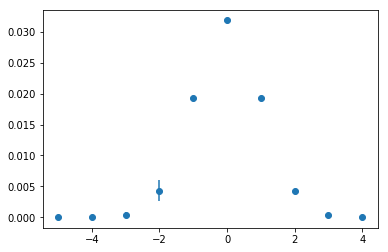

In [23]:
for i in range(400):
    extend(i%5==0)
    x,y,e = [],[],[]
    for a in A:
        x.append(a)
        y.append(A[a][0])
        e.append(A[a][1])
        import matplotlib.pyplot as plt
        plt.clf()
        plt.errorbar(x, y, yerr=e, fmt='o')
        plt.savefig("./imgs/%03d.png" % i)

In [8]:
A

{-5.0: (0.018051424177516203, 0.09229230001656227),
 -4.0: (0.018051424177516203, 0.09229230001656227),
 -3.0: (0.018051424177516203, 0.09229230001656227),
 -2.0: (0.018051424177516203, 0.09229230001656227),
 -1.0: (0.018051424177516203, 0.09229230001656227),
 0.0: (0.018051424177516203, 0.09229230001656227),
 1.0: (0.018051424177516203, 0.09229230001656227),
 2.0: (0.018051424177516203, 0.09229230001656227),
 3.0: (0.018051424177516203, 0.09229230001656227),
 4.0: (1.1478143374528859e-05, 0.09170932504500887)}